In [1]:
import numpy as np
import pandas as pd
import sklearn.linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fmin_tnc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score

**Titanic**

In [2]:
Titanic=pd.read_csv("Titanic/tested.csv")

In [3]:
Titanic=Titanic.drop(columns=["PassengerId","Ticket","Name"])

In [4]:
Titanic.loc[pd.isna(Titanic.Cabin)==False,"Cabin"]=1

In [5]:
Titanic.loc[pd.isna(Titanic.Cabin)==True,"Cabin"]=0

In [6]:
Titanic.loc[:,"Sex"]=(Titanic.Sex=="male").astype(int)

In [7]:
Titanic.loc[pd.isna(Titanic.Age)==True,"Age"]=Titanic.Age.median()

In [8]:
Titanic=pd.get_dummies(Titanic,columns=["Embarked"], drop_first = True)

In [9]:
Titanic.loc[:,"Cabin"]=Titanic.loc[:,"Cabin"].astype(int)

In [10]:
Titanic = Titanic[~Titanic.isnull().any(axis = 1)]

In [11]:
Titanic = Titanic.drop(columns = ['Sex'])

**Diabets**

In [12]:
Diabetes=pd.read_csv("diabetes/dataset_37_diabetes.csv")

In [13]:
Diabetes.loc[:,"class"]=(Diabetes["class"]=="tested_positive").astype(int)

**Pokemon**

In [14]:
Pokemon=pd.read_csv("Pokemon/pokemon.csv")

In [15]:
Pokemon=Pokemon.filter(regex='^(?!against).*')

In [16]:
Pokemon=Pokemon.drop(columns=["abilities","classfication","pokedex_number","japanese_name","name"])

In [17]:
Pokemon.loc[pd.isna(Pokemon.height_m),"height_m"]=0

In [18]:
Pokemon.loc[pd.isna(Pokemon.percentage_male),"percentage_male"]=0

In [19]:
Pokemon.loc[pd.isna(Pokemon.weight_kg),"weight_kg"]=0

In [20]:
Pokemon.capture_rate=pd.to_numeric(Pokemon.capture_rate,errors="coerce")

In [21]:
Pokemon.loc[pd.isna(Pokemon.capture_rate),"capture_rate"]=255

In [22]:
types1=pd.get_dummies(Pokemon["type1"],columns=["type1"], drop_first = True)

In [23]:
types2=pd.get_dummies(Pokemon["type2"],columns=["type2"], drop_first = True)

In [24]:
Pokemon=Pokemon.drop(columns=["type1","type2"])

In [25]:
Pokemon=pd.concat([Pokemon,types2+types1], axis=1)

In [26]:
Pokemon=Pokemon[['base_egg_steps', 'base_happiness', 'base_total',
                'percentage_male', 'sp_attack', 'is_legendary']]

**Cancer**

In [27]:
Cancer=pd.read_csv("cancer/wdbc.data",header=None)

In [28]:
Cancer.iloc[:,1]=(Cancer[1]=="M").astype(int)

In [29]:
Cancer=Cancer.drop(columns=[0])

**Bank**

In [30]:
Bank=pd.read_csv("bank/bank.csv",sep=";")

In [31]:
Bank.loc[:,"default"]=(Bank.default=="yes").astype(int)

In [32]:
Bank.loc[:,"housing"]=(Bank.housing=="yes").astype(int)

In [33]:
Bank.loc[:,"loan"]=(Bank.loan=="yes").astype(int)

In [34]:
Bank.loc[:,"y"]=(Bank.y=="yes").astype(int)

In [35]:
Bank=pd.get_dummies(Bank, drop_first = True)

**Model assessement**

In [36]:
def accuracy(Y,Y_hat):
    temp=Y==Y_hat
    return np.mean(temp)

In [37]:
def precision(Y,Y_hat):
    tp=np.logical_and(Y,Y_hat)
    fp=np.logical_and(np.logical_not(Y),Y_hat)
    return np.sum(tp)/(np.sum(tp)+np.sum(fp))

In [38]:
def recall(Y,Y_hat):
    tp=np.logical_and(Y,Y_hat)
    fn=np.logical_and(Y,np.logical_not(Y_hat))
    return np.sum(tp)/(np.sum(tp)+np.sum(fn))

In [39]:
def F_measure(Y,Y_hat):
    pre=precision(Y,Y_hat)
    re=recall(Y,Y_hat)
    return 2*pre*re/(pre+re)

In [40]:
def assess(Y, Y_hat):
    print('Acccuracy: ', accuracy(Y, Y_hat))
    print('Precision: ', precision(Y, Y_hat))
    print('Recall: ', recall(Y, Y_hat))
    print('F_measure: ', F_measure(Y, Y_hat))
    print('R2_score: ', r2_score(Y, Y_hat))

**Auxiliary Gradient Descent Functions**

In [41]:
def MSE(Y,Y_hat):
    return np.sum((Y-Y_hat)**2)

def MSE_grad(Y,Y_hat):
     return Y_hat-Y

def sigmoid(x):
    return(1/(1 + np.exp(np.clip(-x,-100,100))))

def sigmoid_grad(x):
    return(sigmoid(x)*(1-sigmoid(x)))

def cross_entropy(Y, Y_hat,  epsilon=1e-10):
    Y_hat = np.clip(Y_hat, epsilon, 1-epsilon)
    return np.sum(np.log(Y_hat) * Y + np.log((1 - Y_hat)) * (1 - Y))

def cross_entropy_grad(Y,Y_hat,eps=10**-10):
    Y_hat=Y_hat+eps
    return (Y_hat-eps-Y)/Y_hat/(1-Y_hat)

In [42]:
class LogisticRegression:
    
    def __init__(self, solver: str, intercept: bool = True, iterations: int = 1000, 
                 alpha: int = None, batch_size: int = None, eps = 10**-8,
                 normalize: bool = False, tol = 0.0001):
        
        
        self.solver = solver
        self.intercept = intercept
        self.iterations = iterations
        self.batch_size = batch_size
        self.alpha = alpha
        self.normalize = normalize
        self.tolerance = tol
        self.epsilon = eps
        
    def fit(self, X, Y, verbose = False, save_errors = False):

        if self.normalize:
            X = (X-X.mean(0))/X.std(0)
            
        if self.intercept:
            X = np.insert(X, 0, values=1, axis=1)
            
        self.Beta=np.zeros(X.shape[1])
        
        if self.solver == 'gd':
            self._gradient_descent(X, Y, X.shape[0], verbose, save_errors)
        elif self.solver == 'sgd':
            self._gradient_descent(X, Y, self.batch_size, verbose, save_errors)
        elif self.solver == 'powell':
            self._powell(X, Y)
        else:
            self._iwls(X, Y, verbose, save_errors)
    
    def _gradient_descent(self, X, Y, batch_size, verbose, save_errors):
        
        batches = np.linspace(0,X.shape[0],int(X.shape[0]/batch_size)+1).astype(int)
        
        if save_errors:
            self.errors = [cross_entropy(Y, sigmoid(X @ self.Beta))]
        
        for epoch in range(self.iterations):
            s = np.arange(0, X.shape[0], 1)
            np.random.shuffle(s)
            
            X = X[s,:]
            Y = Y[s]
            
            for b in range(len(batches)-1):
                X_b=X[batches[b]:batches[b+1],:]
                Y_b=Y[batches[b]:batches[b+1]]
                
                pred=sigmoid(X_b @ self.Beta)
                error=cross_entropy(Y_b,pred)
                
                delta = self.alpha * (X_b*(cross_entropy_grad(Y_b,pred) * sigmoid_grad(X_b @ self.Beta)).reshape(-1,1)).mean(axis=0)
                if abs(delta.max()) < self.tolerance:
                    return

                self.Beta = self.Beta - delta
                
            pred=sigmoid(X @ self.Beta)
            error=cross_entropy(Y,pred)
            
            if save_errors:
                self.errors.append(error)
            
            if verbose: 
                print('Iteration no.', epoch+1, ':', error)
                
    
    def _iwls(self, X, Y, verbose, save_errors):
        
        W = np.ones(X.shape[0])*0.5
        X1 = X[:,1:] if self.intercept else X
        
        if save_errors:
            self.errors = [cross_entropy(Y, sigmoid(X @ self.Beta))]
        
        for i in range(self.iterations):
            
            delta = np.linalg.inv((X.T * W[:,None].T) @ X) @ X.T @ (Y-self.predict(X1))
            if abs(delta.max()) < self.tolerance:
                return
            
            self.Beta += delta

            W = (1-self.predict(X1)) * self.predict(X1) + self.epsilon
            
            pred = sigmoid(X @ self.Beta)
            error = cross_entropy(Y, pred)
            
            if save_errors:
                self.errors.append(error)
            
            if verbose: 
                print('Iteration no.', i+1, ':', error)

    def _powell(self, X, Y):
        self.Beta = minimize(fun = lambda x: -cross_entropy(Y, sigmoid(X @ x)), x0 = self.Beta, 
                             method = 'Powell',options={'xtol': self.tolerance, 'maxiter': self.iterations}).x
    
    def predict(self, X, rounding = False):
        
        if self.normalize:
            X = (X-X.mean(0))/X.std(0)
            
        if self.intercept:
            X = np.insert(X, 0, values=1, axis=1)
            
        ret = np.exp(np.clip(X @ self.Beta, -100, 100))/(1+np.exp(np.clip(X @ self.Beta, -100, 100)))
        
        if rounding:
            ret = ret.round()

        return ret
    

**Cancer**

In [43]:
np.random.seed(111)
Y = Cancer[1].to_numpy()
X = Cancer.loc[:,2:].to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [44]:
mod_sgd = LogisticRegression('sgd', alpha = 0.1, batch_size = 100, normalize = True)
mod_sgd.fit(X_train, Y_train, verbose = True, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

Iteration no. 1 : -158.88853543873998
Iteration no. 2 : -122.54836267002526
Iteration no. 3 : -104.79193869519422
Iteration no. 4 : -93.67644596285164
Iteration no. 5 : -85.90976234839403
Iteration no. 6 : -80.08481651554258
Iteration no. 7 : -75.51958904525705
Iteration no. 8 : -71.82854021656377
Iteration no. 9 : -68.76492051604058
Iteration no. 10 : -66.17791351147598
Iteration no. 11 : -63.957563323457165
Iteration no. 12 : -62.025690029425036
Iteration no. 13 : -60.32466785811319
Iteration no. 14 : -58.81309073005618
Iteration no. 15 : -57.46085282318394
Iteration no. 16 : -56.239009970225396
Iteration no. 17 : -55.130403575841626
Iteration no. 18 : -54.11913544449864
Iteration no. 19 : -53.19089326194663
Iteration no. 20 : -52.33531202889323
Iteration no. 21 : -51.54382643547268
Iteration no. 22 : -50.80868885532784
Iteration no. 23 : -50.123008388711874
Iteration no. 24 : -49.482976662357835
Iteration no. 25 : -48.882784359175496
Iteration no. 26 : -48.31781844764684
Iteration n

In [45]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.9736842105263158
Precision:  0.9767441860465116
Recall:  0.9545454545454546
F_measure:  0.9655172413793104
R2_score:  0.888961038961039


In [46]:
mod_gd = LogisticRegression('gd', alpha = 0.1, normalize = True)
mod_gd.fit(X_train, Y_train, verbose = True, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

Iteration no. 1 : -238.39442025702206
Iteration no. 2 : -199.18382755670152
Iteration no. 3 : -175.15119005756748
Iteration no. 4 : -158.58534542023475
Iteration no. 5 : -146.30025239474062
Iteration no. 6 : -136.7273345412594
Iteration no. 7 : -128.99689483808535
Iteration no. 8 : -122.58426869926275
Iteration no. 9 : -117.15231184289806
Iteration no. 10 : -112.47346058728111
Iteration no. 11 : -108.38793270588329
Iteration no. 12 : -104.77984191943087
Iteration no. 13 : -101.56282830820658
Iteration no. 14 : -98.67103678245003
Iteration no. 15 : -96.05324545738671
Iteration no. 16 : -93.6689243421358
Iteration no. 17 : -91.48551795602972
Iteration no. 18 : -89.47652731507092
Iteration no. 19 : -87.62012776469848
Iteration no. 20 : -85.89815438732809
Iteration no. 21 : -84.29534479927878
Iteration no. 22 : -82.79876554582755
Iteration no. 23 : -81.39737166563633
Iteration no. 24 : -80.08166432418673
Iteration no. 25 : -78.84342167415966
Iteration no. 26 : -77.67548509092961
Iteration 

Iteration no. 243 : -38.60812976504535
Iteration no. 244 : -38.570530101911814
Iteration no. 245 : -38.533158037924935
Iteration no. 246 : -38.49601120988109
Iteration no. 247 : -38.459087288933304
Iteration no. 248 : -38.42238397995486
Iteration no. 249 : -38.385899020917066
Iteration no. 250 : -38.34963018228096
Iteration no. 251 : -38.31357526640254
Iteration no. 252 : -38.277732106951234
Iteration no. 253 : -38.2420985683411
Iteration no. 254 : -38.20667254517463
Iteration no. 255 : -38.1714519616987
Iteration no. 256 : -38.13643477127242
Iteration no. 257 : -38.10161895584652
Iteration no. 258 : -38.06700252545396
Iteration no. 259 : -38.03258351771171
Iteration no. 260 : -37.998359997333026
Iteration no. 261 : -37.96433005565028
Iteration no. 262 : -37.93049181014798
Iteration no. 263 : -37.89684340400561
Iteration no. 264 : -37.863383005650284
Iteration no. 265 : -37.83010880831873
Iteration no. 266 : -37.79701902962853
Iteration no. 267 : -37.76411191115827
Iteration no. 268 : 

Iteration no. 493 : -33.07222043489513
Iteration no. 494 : -33.05870215753206
Iteration no. 495 : -33.04522272603424
Iteration no. 496 : -33.03178194796538
Iteration no. 497 : -33.01837963224698
Iteration no. 498 : -33.00501558914589
Iteration no. 499 : -32.99168963026193
Iteration no. 500 : -32.978401568515736
Iteration no. 501 : -32.96515121813671
Iteration no. 502 : -32.951938394651094
Iteration no. 503 : -32.93876291487016
Iteration no. 504 : -32.92562459687859
Iteration no. 505 : -32.91252326002297
Iteration no. 506 : -32.8994587249003
Iteration no. 507 : -32.88643081334683
Iteration no. 508 : -32.87343934842685
Iteration no. 509 : -32.8604841544217
Iteration no. 510 : -32.847565056818844
Iteration no. 511 : -32.83468188230108
Iteration no. 512 : -32.82183445873595
Iteration no. 513 : -32.80902261516506
Iteration no. 514 : -32.79624618179378
Iteration no. 515 : -32.78350498998081
Iteration no. 516 : -32.77079887222812
Iteration no. 517 : -32.75812766217067
Iteration no. 518 : -32.

Iteration no. 747 : -30.525271304765642
Iteration no. 748 : -30.517753997161265
Iteration no. 749 : -30.510250798658987
Iteration no. 750 : -30.502761663357223
Iteration no. 751 : -30.495286545563275
Iteration no. 752 : -30.487825399792108
Iteration no. 753 : -30.480378180765126
Iteration no. 754 : -30.472944843408943
Iteration no. 755 : -30.46552534285417
Iteration no. 756 : -30.458119634434233
Iteration no. 757 : -30.450727673684153
Iteration no. 758 : -30.443349416339373
Iteration no. 759 : -30.435984818334582
Iteration no. 760 : -30.428633835802543
Iteration no. 761 : -30.421296425072953
Iteration no. 762 : -30.413972542671253
Iteration no. 763 : -30.406662145317522
Iteration no. 764 : -30.39936518992534
Iteration no. 765 : -30.39208163360063
Iteration no. 766 : -30.38481143364057
Iteration no. 767 : -30.37755454753249
Iteration no. 768 : -30.37031093295273
Iteration no. 769 : -30.363080547765584
Iteration no. 770 : -30.355863350022215
Iteration no. 771 : -30.34865929795953
Iterati

In [47]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.9736842105263158
Precision:  0.9767441860465116
Recall:  0.9545454545454546
F_measure:  0.9655172413793104
R2_score:  0.888961038961039


In [48]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-6)
mod_iwls.fit(X_train, Y_train, verbose = True, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

Iteration no. 1 : -179.03412927319164
Iteration no. 2 : -87.78824330380176
Iteration no. 3 : -52.68282093632001
Iteration no. 4 : -34.92479402511893
Iteration no. 5 : -24.841742001004512
Iteration no. 6 : -17.401738579895497
Iteration no. 7 : -10.731459574521729
Iteration no. 8 : -6.137317083706627
Iteration no. 9 : -2.9073937252599524
Iteration no. 10 : -1.2321894049340807
Iteration no. 11 : -0.5280352783850019
Iteration no. 12 : -0.2574565519481355
Iteration no. 13 : -0.1479463037047916
Iteration no. 14 : -0.09768520655408594
Iteration no. 15 : -0.07106526422904931
Iteration no. 16 : -0.055177972437170195
Iteration no. 17 : -0.04481179647399073
Iteration no. 18 : -0.03758749548826157
Iteration no. 19 : -0.03229635263580749
Iteration no. 20 : -0.028269305642628743
Iteration no. 21 : -0.02510972827016345
Iteration no. 22 : -0.0225690949305641
Iteration no. 23 : -0.0204844381799922
Iteration no. 24 : -0.018744778405573554
Iteration no. 25 : -0.017272094967552092
Iteration no. 26 : -0.01

Iteration no. 209 : -0.0010812880602109598
Iteration no. 210 : -0.0010757810923930139
Iteration no. 211 : -0.0010703298718687491
Iteration no. 212 : -0.0010649335570604517
Iteration no. 213 : -0.0010595913232354648
Iteration no. 214 : -0.001054302362086779
Iteration no. 215 : -0.0010490658813260664
Iteration no. 216 : -0.0010438811042910333
Iteration no. 217 : -0.0010387472695577741
Iteration no. 218 : -0.0010336636305745541
Iteration no. 219 : -0.0010286294552948184
Iteration no. 220 : -0.001023644025833626
Iteration no. 221 : -0.0010187066381185375
Iteration no. 222 : -0.0010138166015694814
Iteration no. 223 : -0.0010089732387661859
Iteration no. 224 : -0.0010041758851438132
Iteration no. 225 : -0.0009994238886904849
Iteration no. 226 : -0.0009947166096425843
Iteration no. 227 : -0.0009900534202123726
Iteration no. 228 : -0.0009854337042976176
Iteration no. 229 : -0.0009808568572193144
Iteration no. 230 : -0.0009763222854519674
Iteration no. 231 : -0.0009718294063713066
Iteration no.

Iteration no. 415 : -0.0005261110024770094
Iteration no. 416 : -0.0005248024366215219
Iteration no. 417 : -0.0005235003610518996
Iteration no. 418 : -0.0005222047276188255
Iteration no. 419 : -0.0005209154886501913
Iteration no. 420 : -0.0005196325969392176
Iteration no. 421 : -0.0005183560057460075
Iteration no. 422 : -0.0005170856687865551
Iteration no. 423 : -0.0005158215402287481
Iteration no. 424 : -0.0005145635746877044
Iteration no. 425 : -0.0005133117272193324
Iteration no. 426 : -0.0005120659533157786
Iteration no. 427 : -0.0005108262088992096
Iteration no. 428 : -0.0005095924503184816
Iteration no. 429 : -0.0005083646343412571
Iteration no. 430 : -0.0005071427181504509
Iteration no. 431 : -0.0005059266593400127
Iteration no. 432 : -0.0005047164159087075
Iteration no. 433 : -0.0005035119462551204
Iteration no. 434 : -0.0005023132091753243
Iteration no. 435 : -0.0005011201638551077
Iteration no. 436 : -0.0004999327698677549
Iteration no. 437 : -0.0004987509871667163
Iteration n

Iteration no. 612 : -0.00035278964931817675
Iteration no. 613 : -0.00035220060453000873
Iteration no. 614 : -0.0003516135230310168
Iteration no. 615 : -0.00035102839502176375
Iteration no. 616 : -0.00035044521077287095
Iteration no. 617 : -0.000349863960616469
Iteration no. 618 : -0.0003492846349481966
Iteration no. 619 : -0.0003487072242287544
Iteration no. 620 : -0.00034813171898401664
Iteration no. 621 : -0.0003475581097965925
Iteration no. 622 : -0.0003469863873140427
Iteration no. 623 : -0.0003464165422476573
Iteration no. 624 : -0.0003458485653657952
Iteration no. 625 : -0.0003452824474979913
Iteration no. 626 : -0.00034471817953573376
Iteration no. 627 : -0.00034415575242780145
Iteration no. 628 : -0.00034359515718348284
Iteration no. 629 : -0.00034303638486880204
Iteration no. 630 : -0.00034247942660884945
Iteration no. 631 : -0.000341924273586561
Iteration no. 632 : -0.00034137091704071975
Iteration no. 633 : -0.00034081934826784275
Iteration no. 634 : -0.0003402695586195169
I

Iteration no. 813 : -0.00026402743666467627
Iteration no. 814 : -0.00026369734142922145
Iteration no. 815 : -0.0002633680704713749
Iteration no. 816 : -0.000263039620707845
Iteration no. 817 : -0.0002627119890704399
Iteration no. 818 : -0.00026238517250762176
Iteration no. 819 : -0.00026205916798084265
Iteration no. 820 : -0.0002617339724700961
Iteration no. 821 : -0.0002614095829664783
Iteration no. 822 : -0.0002610859964782946
Iteration no. 823 : -0.00026076321002783964
Iteration no. 824 : -0.00026044122065128623
Iteration no. 825 : -0.00026012002540201645
Iteration no. 826 : -0.00025979962134551406
Iteration no. 827 : -0.00025948000556269557
Iteration no. 828 : -0.000259161175148578
Iteration no. 829 : -0.0002588431272130556
Iteration no. 830 : -0.0002585258588783468
Iteration no. 831 : -0.00025820936728310174
Iteration no. 832 : -0.00025789364957851666
Iteration no. 833 : -0.0002575787029301101
Iteration no. 834 : -0.0002572645245167239
Iteration no. 835 : -0.0002569511115319662
It

In [49]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.9298245614035088
Precision:  0.9090909090909091
Recall:  0.9090909090909091
F_measure:  0.9090909090909091
R2_score:  0.7038961038961039


In [50]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [51]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.9298245614035088
Precision:  0.9090909090909091
Recall:  0.9090909090909091
F_measure:  0.9090909090909091
R2_score:  0.7038961038961039


In [52]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_test.mean(0))/X_test.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [53]:
assess(Y_test, Y_hat)

Acccuracy:  0.9736842105263158
Precision:  0.9767441860465116
Recall:  0.9545454545454546
F_measure:  0.9655172413793104
R2_score:  0.888961038961039


In [54]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [55]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.956140350877193
Precision:  0.975609756097561
Recall:  0.9090909090909091
F_measure:  0.9411764705882352
R2_score:  0.814935064935065


In [56]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [57]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.9385964912280702
Precision:  0.8627450980392157
Recall:  1.0
F_measure:  0.9263157894736842
R2_score:  0.740909090909091


In [58]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [59]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.9824561403508771
Precision:  0.9772727272727273
Recall:  0.9772727272727273
F_measure:  0.9772727272727273
R2_score:  0.925974025974026


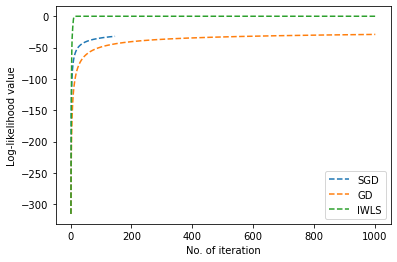

In [60]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Log-likelihood value')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.show()

In [61]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

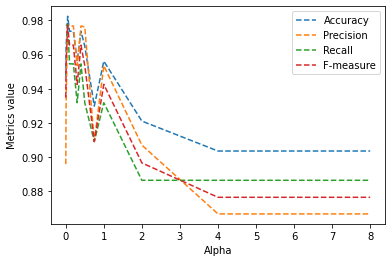

In [62]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

In [63]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

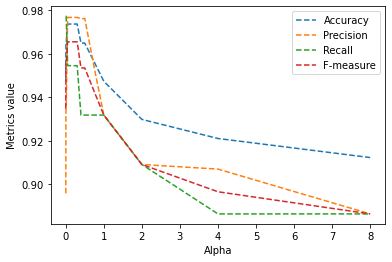

In [64]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

**Bank**

In [65]:
np.random.seed(111)
Y = Bank['y'].to_numpy()
X = Bank.drop(columns=['y']).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [66]:
mod_sgd = LogisticRegression('sgd', alpha = 0.5, batch_size = 1000, normalize = True)
mod_sgd.fit(X_train, Y_train, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

In [67]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.8961325966850828
Precision:  0.6590909090909091
Recall:  0.26851851851851855
F_measure:  0.3815789473684211
R2_score:  0.01168734606626709


In [68]:
mod_gd = LogisticRegression('gd', alpha = 0.5, normalize = True)
mod_gd.fit(X_train, Y_train, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

In [69]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.8950276243093923
Precision:  0.6511627906976745
Recall:  0.25925925925925924
F_measure:  0.3708609271523179
R2_score:  0.0011733816627167437


In [70]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-8)
mod_iwls.fit(X_train, Y_train, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

In [71]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.8961325966850828
Precision:  0.6590909090909091
Recall:  0.26851851851851855
F_measure:  0.3815789473684211
R2_score:  0.01168734606626709


In [72]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [73]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.8961325966850828
Precision:  0.6590909090909091
Recall:  0.26851851851851855
F_measure:  0.3815789473684211
R2_score:  0.01168734606626709


In [74]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_test.mean(0))/X_test.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [75]:
assess(Y_test, Y_hat)

Acccuracy:  0.8961325966850828
Precision:  0.6590909090909091
Recall:  0.26851851851851855
F_measure:  0.3815789473684211
R2_score:  0.01168734606626709


In [76]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [77]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.901657458563536
Precision:  0.6301369863013698
Recall:  0.42592592592592593
F_measure:  0.5082872928176796
R2_score:  0.06425716808401893


In [78]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [79]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.8541436464088398
Precision:  0.4032258064516129
Recall:  0.46296296296296297
F_measure:  0.4310344827586207
R2_score:  -0.3878433012686462


In [80]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [81]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.8850828729281768
Precision:  0.5526315789473685
Recall:  0.19444444444444445
F_measure:  0.28767123287671237
R2_score:  -0.09345229796923626


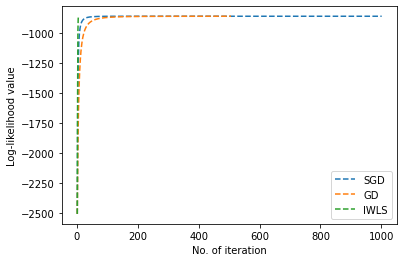

In [82]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Log-likelihood value')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.show()

In [83]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

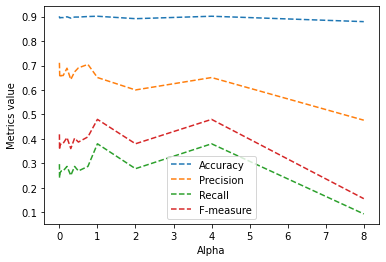

In [84]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

In [85]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

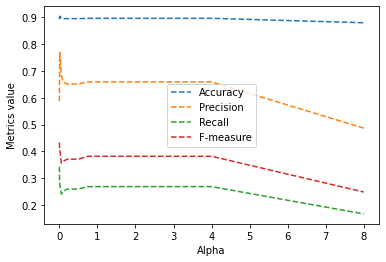

In [86]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

**Pokemon**

In [87]:
np.random.seed(111)
Y = Pokemon["is_legendary"].to_numpy()
X = Pokemon.drop(columns=["is_legendary"]).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [88]:
mod_sgd = LogisticRegression('sgd', alpha = 0.01, batch_size = 200, normalize = True)
mod_sgd.fit(X_train, Y_train, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

In [89]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.9813664596273292
Precision:  0.9090909090909091
Recall:  0.8333333333333334
F_measure:  0.8695652173913043
R2_score:  0.7298657718120806


In [90]:
mod_gd = LogisticRegression('gd', alpha = 0.01, normalize = True)
mod_gd.fit(X_train, Y_train, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

In [91]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.9813664596273292
Precision:  0.9090909090909091
Recall:  0.8333333333333334
F_measure:  0.8695652173913043
R2_score:  0.7298657718120806


In [92]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-6)
mod_iwls.fit(X_train, Y_train, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

In [93]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.968944099378882
Precision:  0.7692307692307693
Recall:  0.8333333333333334
F_measure:  0.8
R2_score:  0.5497762863534676


In [94]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [95]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.968944099378882
Precision:  0.7692307692307693
Recall:  0.8333333333333334
F_measure:  0.8
R2_score:  0.5497762863534676


In [96]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_test.mean(0))/X_test.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [97]:
assess(Y_test, Y_hat)

Acccuracy:  0.9751552795031055
Precision:  0.8333333333333334
Recall:  0.8333333333333334
F_measure:  0.8333333333333334
R2_score:  0.639821029082774


In [98]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [99]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.9813664596273292
Precision:  0.9090909090909091
Recall:  0.8333333333333334
F_measure:  0.8695652173913043
R2_score:  0.7298657718120806


In [100]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [101]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.9565217391304348
Precision:  0.6666666666666666
Recall:  0.8333333333333334
F_measure:  0.7407407407407408
R2_score:  0.3696868008948546


In [102]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [103]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.9751552795031055
Precision:  0.8333333333333334
Recall:  0.8333333333333334
F_measure:  0.8333333333333334
R2_score:  0.639821029082774


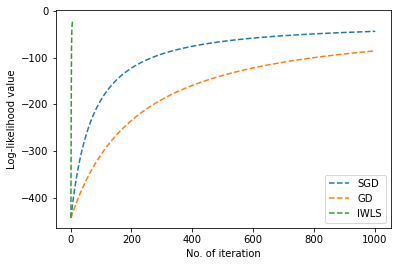

In [104]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Log-likelihood value')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.show()

In [105]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

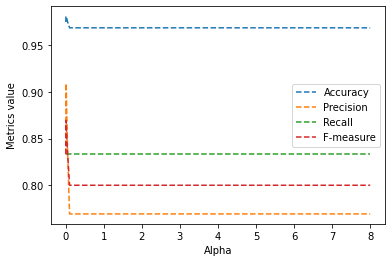

In [106]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

In [107]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

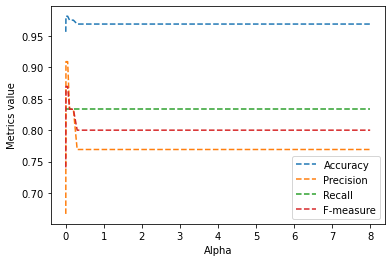

In [108]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

**Diabetes**

In [109]:
X.shape

(801, 5)

In [110]:
np.random.seed(111)
Y = Diabetes["class"].to_numpy()
X = Diabetes.drop(columns=["class"]).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [111]:
mod_sgd = LogisticRegression('sgd', alpha = 0.5, batch_size = 200, normalize = True)
mod_sgd.fit(X_train, Y_train, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

In [112]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.7402597402597403
Precision:  0.6511627906976745
Recall:  0.5283018867924528
F_measure:  0.5833333333333333
R2_score:  -0.15075658509247125


In [113]:
mod_gd = LogisticRegression('gd',alpha = 0.01, normalize = True)
mod_gd.fit(X_train, Y_train, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

In [114]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.7272727272727273
Precision:  0.627906976744186
Recall:  0.5094339622641509
F_measure:  0.5625
R2_score:  -0.20829441434709484


In [115]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-5)
mod_iwls.fit(X_train, Y_train, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

In [116]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.7402597402597403
Precision:  0.6511627906976745
Recall:  0.5283018867924528
F_measure:  0.5833333333333333
R2_score:  -0.15075658509247125


In [117]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [118]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.7402597402597403
Precision:  0.6511627906976745
Recall:  0.5283018867924528
F_measure:  0.5833333333333333
R2_score:  -0.15075658509247125


In [119]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_test.mean(0))/X_test.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [120]:
assess(Y_test, Y_hat)

Acccuracy:  0.7467532467532467
Precision:  0.6666666666666666
Recall:  0.5283018867924528
F_measure:  0.5894736842105263
R2_score:  -0.12198767046515946


In [121]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [122]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.7402597402597403
Precision:  0.6585365853658537
Recall:  0.5094339622641509
F_measure:  0.574468085106383
R2_score:  -0.15075658509247125


In [123]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [124]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.7077922077922078
Precision:  0.5833333333333334
Recall:  0.5283018867924528
F_measure:  0.5544554455445545
R2_score:  -0.29460115822903


In [125]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [126]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.6883116883116883
Precision:  0.5531914893617021
Recall:  0.49056603773584906
F_measure:  0.52
R2_score:  -0.38090790211096537


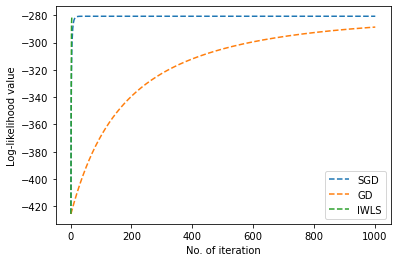

In [127]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Log-likelihood value')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.show()

In [128]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

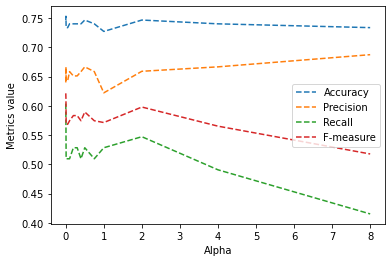

In [129]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

In [130]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

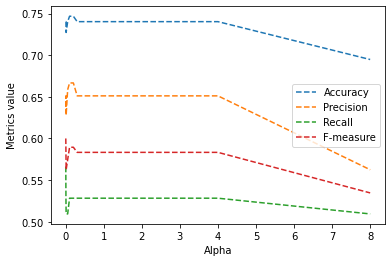

In [131]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

**Titanic**

In [132]:
X.shape

(768, 8)

In [133]:
np.random.seed(111)
Y = Titanic["Survived"].to_numpy()
X = Titanic.drop(columns=["Survived"]).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [134]:
mod_sgd = LogisticRegression('sgd', alpha = 0.1, batch_size = 100, normalize = True)
mod_sgd.fit(X_train, Y_train, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

In [135]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.5357142857142857
Precision:  0.75
Recall:  0.07317073170731707
F_measure:  0.13333333333333333
R2_score:  -0.8581962563811689


In [136]:
mod_gd = LogisticRegression('gd', alpha = 0.1, normalize = True)
mod_gd.fit(X_train, Y_train, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

In [137]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.5357142857142857
Precision:  0.75
Recall:  0.07317073170731707
F_measure:  0.13333333333333333
R2_score:  -0.8581962563811689


In [138]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-5)
mod_iwls.fit(X_train, Y_train, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

In [139]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.5357142857142857
Precision:  0.75
Recall:  0.07317073170731707
F_measure:  0.13333333333333333
R2_score:  -0.8581962563811689


In [140]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [141]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.5357142857142857
Precision:  0.75
Recall:  0.07317073170731707
F_measure:  0.13333333333333333
R2_score:  -0.8581962563811689


In [142]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_test.mean(0))/X_test.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [143]:
assess(Y_test, Y_hat)

Acccuracy:  0.5357142857142857
Precision:  0.75
Recall:  0.07317073170731707
F_measure:  0.13333333333333333
R2_score:  -0.8581962563811689


In [144]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [145]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.5357142857142857
Precision:  0.75
Recall:  0.07317073170731707
F_measure:  0.13333333333333333
R2_score:  -0.8581962563811689


In [146]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [147]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.5595238095238095
Precision:  0.625
Recall:  0.24390243902439024
F_measure:  0.3508771929824561
R2_score:  -0.762904140669314


In [148]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [149]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.5833333333333334
Precision:  0.6363636363636364
Recall:  0.34146341463414637
F_measure:  0.4444444444444445
R2_score:  -0.6676120249574593


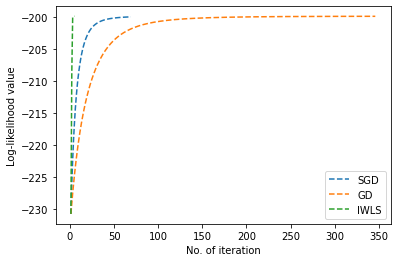

In [150]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Log-likelihood value')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.show()

In [151]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

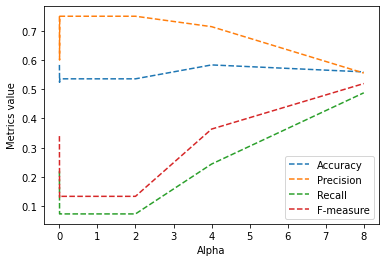

In [152]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

In [153]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

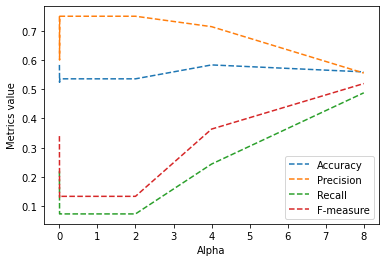

In [154]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()